In [1]:
import sys
import numpy as np
from astropy.io import fits
from aspired import aspired
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

/usr/local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


/Users/marcolam/git/ASPIRED/aspired/aspired.py:289: UserWarning:

saxis keyword "SAXIS" is not in the header. saxis is set to 1.

/Users/marcolam/git/ASPIRED/aspired/aspired.py:523: UserWarning:

No bias frames. Bias subtraction is not performed.

/Users/marcolam/git/ASPIRED/aspired/aspired.py:539: UserWarning:

No flat frames. Field-flattening is not performed.



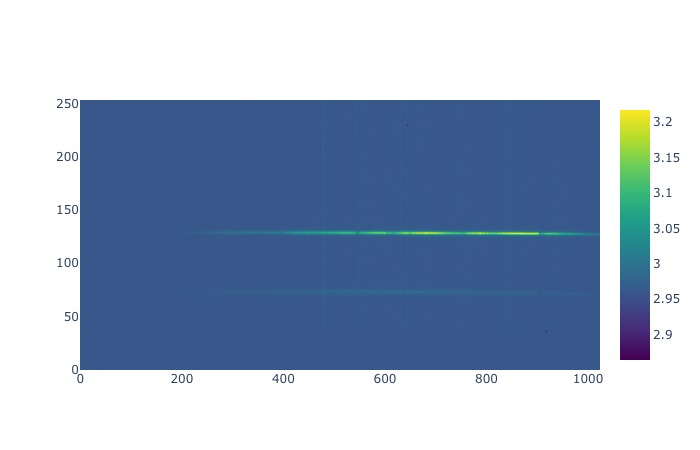

In [2]:
science_frame = aspired.ImageReduction('examples/sprat_LHS6328.list')
science_frame.reduce()
science_frame.inspect(renderer='jpg')
#science_frame.savefits(overwrite=True)

/Users/marcolam/git/ASPIRED/aspired/aspired.py:289: UserWarning:

saxis keyword "SAXIS" is not in the header. saxis is set to 1.

/Users/marcolam/git/ASPIRED/aspired/aspired.py:523: UserWarning:

No bias frames. Bias subtraction is not performed.

/Users/marcolam/git/ASPIRED/aspired/aspired.py:539: UserWarning:

No flat frames. Field-flattening is not performed.



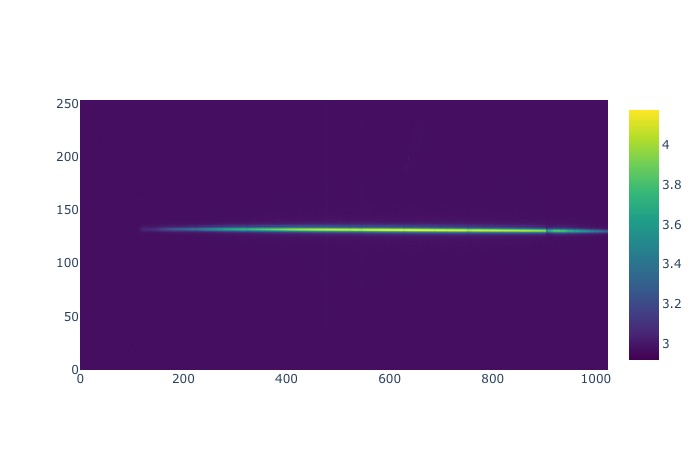

In [3]:
standard_frame = aspired.ImageReduction('examples/sprat_Hiltner102.list')
standard_frame.reduce()
standard_frame.inspect(renderer='jpg')

In [4]:
# Set the spectral direction is defaulted to saxis=1
#saxis = 1

# initialise the two aspired.TwoDSpec()
lhs6328 = aspired.TwoDSpec(
    science_frame,
    cr=False
)
hilt102 = aspired.TwoDSpec(
    standard_frame,
    cr=False
)

/Users/marcolam/git/ASPIRED/aspired/aspired.py:916: UserWarning:

Read Noise value cannot be identified. It is set to 0.



/Users/marcolam/git/SpectRes/spectres/spectral_resampling.py:90: UserWarning:

spectres: Part of the new wavelength range is outside the range of the input data, they are filled with zeros.



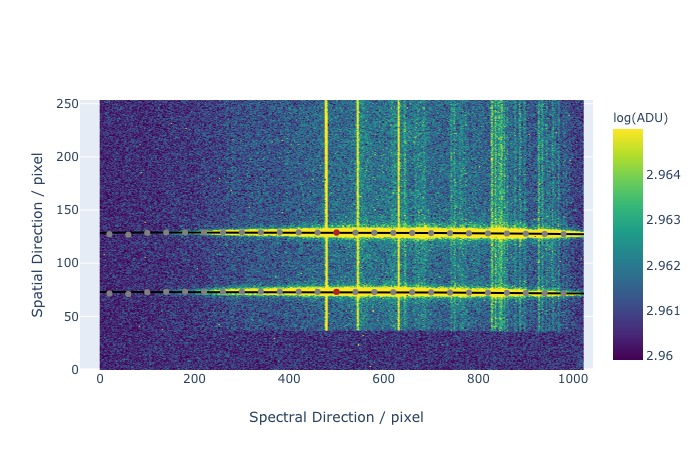

In [5]:
# automatically trace the spectrum
lhs6328.ap_trace(nspec=2, renderer='jpg', display=True)

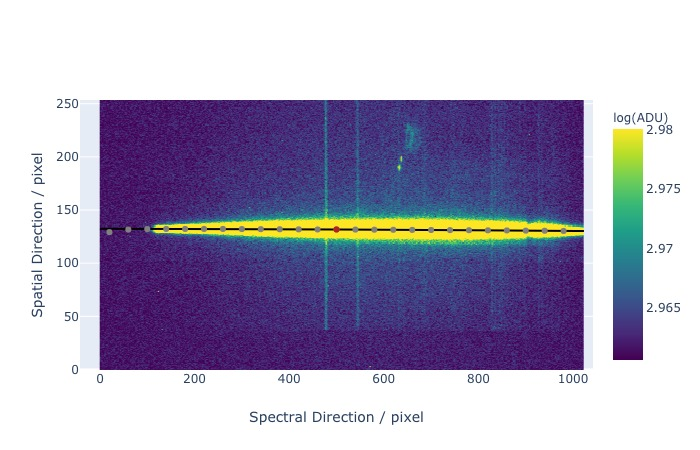

In [6]:
hilt102.ap_trace(nspec=1, renderer='jpg', display=True)

In [7]:
# Uncomment this to supply trace(s) manually, this overwrites the traces found with ap_trace.
# All these should work
#lhs6328.add_trace([np.ones(1024)*130., np.ones(1024)*70.], 5.)
#lhs6328.add_trace(np.ones(1024)*130., 5.)
#lhs6328.add_trace([np.ones(1024)*130.], 5.)
#lhs6328.add_trace([np.ones(1024)*130.], [5.])

# Optimal extracting spectrum by summing over the aperture along the trace
lhs6328.ap_extract(
    apwidth=15,
    optimal=True,
    skywidth=10,
    skydeg=1,
    display=True,
    jsonstring=False)

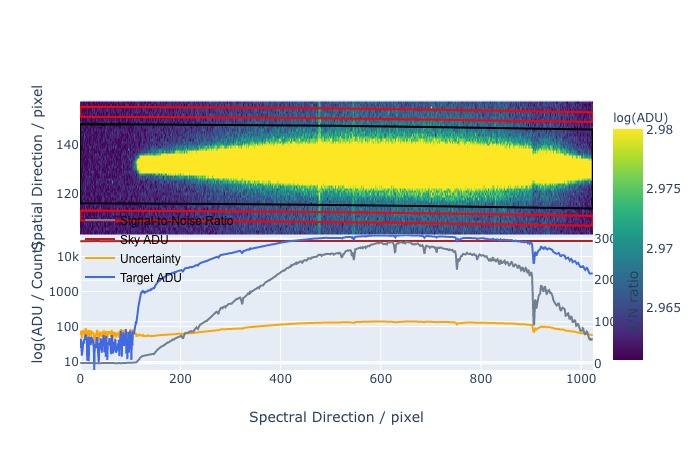

In [8]:
hilt102.ap_extract(
    apwidth=15,
    skysep=3,
    skywidth=5,
    skydeg=1,
    optimal=True,
    display=True,
    jsonstring=False,
renderer='jpg')

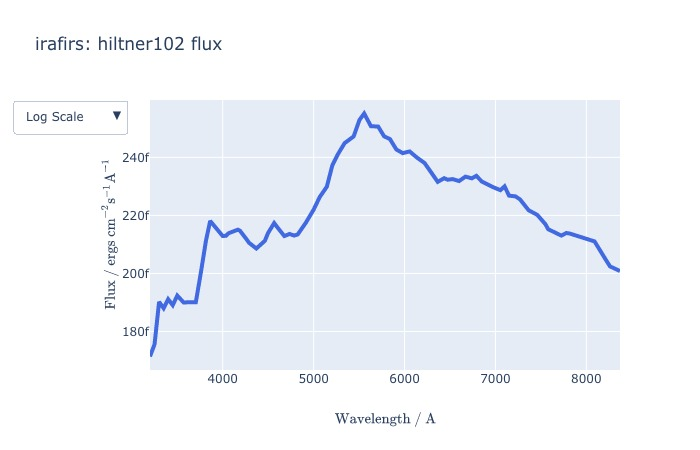

In [9]:
fluxcal = aspired.StandardFlux(
    target='hiltner102',
    group='irafirs',
    cutoff=0.4,
    ftype='flux'
)
fluxcal.load_standard()
fluxcal.inspect_standard(renderer='jpg')

In [10]:
# Placeholder of wavelength calibration
wavecal_science = aspired.WavelengthPolyFit(lhs6328, science_frame)
wavecal_standard = aspired.WavelengthPolyFit(hilt102, standard_frame)

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning:


/Users/marcolam/git/ASPIRED/aspired/aspired.py:2249: RuntimeWarning:

invalid value encountered in log10



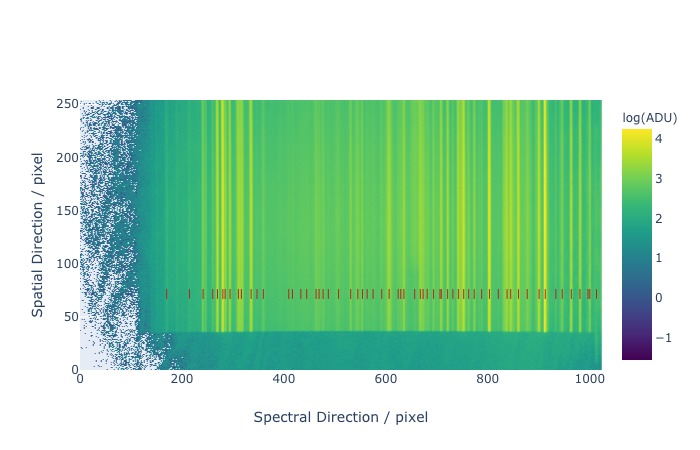

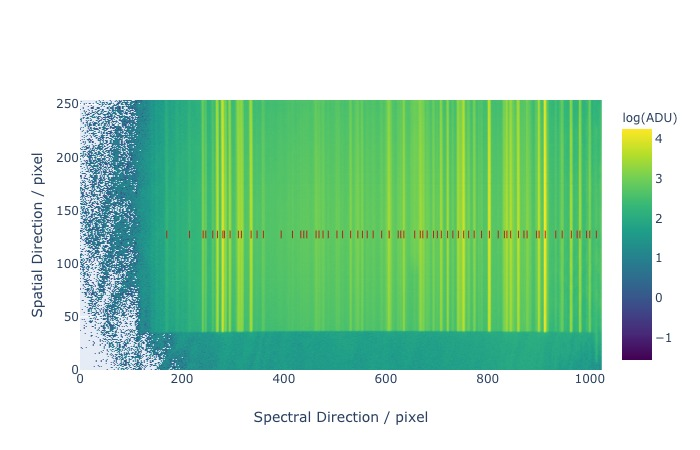

In [11]:
# Find the arc lines, first by subtracting the ADU value at 20-th percentile, as a crude background subtraction
# A minimum of 5 pixels between lines
wavecal_science.find_arc_lines(percentile=20., distance=5., renderer='jpg', display=True)

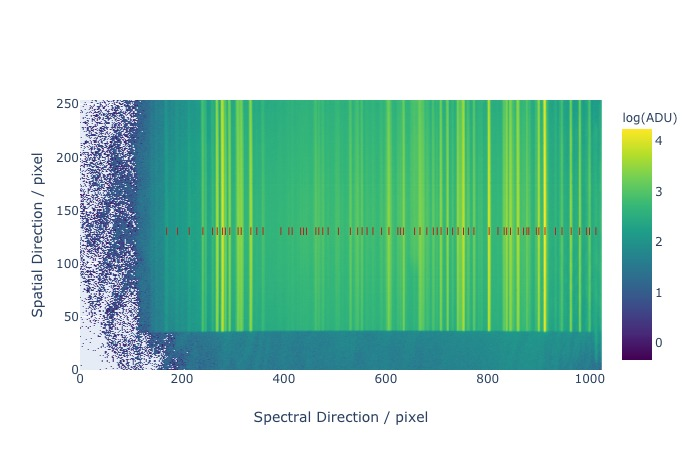

In [12]:
wavecal_standard.find_arc_lines(percentile=20., distance=5., renderer='jpg', display=True)

In [13]:
wavecal_science.fit(elements=["Xe"], candidate_thresh=10., display=False)
wavecal_science.refine_fit(elements=["Xe"], tolerance=20., display=False)
wavecal_science.refine_fit(elements=["Xe"], tolerance=10., display=False)
wavecal_science.refine_fit(elements=["Xe"], tolerance=5., display=True)

In [14]:
wavecal_standard.add_pfit(pfit=np.array((3.51700222e+03, 3.70373795e+00, 1.95416739e-03, -1.84127252e-06, 9.87404779e-10, -2.60486760e-13)))
#wavecal_standard.refine_fit(elements=["Xe"], tolerance=25., display=False)
#wavecal_standard.refine_fit(elements=["Xe"], tolerance=20., display=False)
#wavecal_standard.refine_fit(elements=["Xe"], tolerance=15., display=False)
wavecal_standard.refine_fit(elements=["Xe"], tolerance=10., display=False)
wavecal_standard.refine_fit(elements=["Xe"], tolerance=5., display=True)

In [15]:
print("RMS of the fit: " + str(wavecal_science.rms) + "\n")
print("Polyfit coefficient: " + str(wavecal_science.pfit) + "\n")
print("Fraction of peaks used for wavelength calibration:" + str(wavecal_science.peak_utilisation) + "\n\n")

print("RMS of the fit: " + str(wavecal_standard.rms) + "\n")
print("Polyfit coefficient: " + str(wavecal_standard.pfit) + "\n")
print("Fraction of peaks used for wavelength calibration:" + str(wavecal_standard.peak_utilisation) + "\n")

RMS of the fit: [2.2541046566933267, 1.752682525308296]

Polyfit coefficient: [array([ 3.51067670e+03,  3.77657167e+00,  1.58935927e-03, -1.06480387e-06,
        2.46544342e-10]), array([ 3.50649455e+03,  3.81320825e+00,  1.46296983e-03, -8.92679528e-07,
        1.67860519e-10])]

Fraction of peaks used for wavelength calibration:[0.8524590163934426, 0.8235294117647058]


RMS of the fit: [1.6442643568929585]

Polyfit coefficient: [array([ 3.51700222e+03,  3.70373795e+00,  1.95416739e-03, -1.84127252e-06,
        9.87404779e-10, -2.60486760e-13])]

Fraction of peaks used for wavelength calibration:[0.8636363636363636]



In [16]:
# Get the sensitivity curves
lhs6328_reduced = aspired.OneDSpec(
    lhs6328,
    wavecal_science,
    standard=hilt102,
    wave_cal_std=wavecal_standard,
    flux_cal=fluxcal
)
lhs6328_reduced.apply_wavelength_calibration('science')
lhs6328_reduced.apply_wavelength_calibration('standard')
lhs6328_reduced.compute_sencurve(kind='cubic')
lhs6328_reduced.inspect_sencurve(renderer='iframe')

/Users/marcolam/git/SpectRes/spectres/spectral_resampling.py:90: UserWarning:

spectres: Part of the new wavelength range is outside the range of the input data, they are filled with zeros.

/Users/marcolam/git/ASPIRED/aspired/aspired.py:2997: RuntimeWarning:

divide by zero encountered in true_divide



In [17]:
lhs6328_reduced.apply_flux_calibration('science')
lhs6328_reduced.apply_flux_calibration('standard')

In [18]:
lhs6328_reduced.inspect_reduced_spectrum('science')

In [19]:
lhs6328_reduced.inspect_reduced_spectrum('standard')

In [20]:
#lhs6328_reduced.save_fits(stype='all', overwrite=True)